#### 이 코드는 아래와 같은 환경에서 수행되었습니다. 

VM : kaggle notebook(TPU)

tensorflow :  2.2

rdkit :  2020.03.3

accelerator :  kaggle TPU 

In [ ]:
#모델 넘버
number = '10'

### 텐서플로우 2.2설치 (2.3은 불안정합니다)

In [ ]:
!pip install tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
import tensorflow as tf
import requests
import os
#코랩활용시 아래 주석 해제
# resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
# if resp.status_code != 200:
#   print("Failed to switch the TPU to TF {}".format(version))

### Rdkit 설치합니다

In [ ]:
# # rdkit 2020.03.3 버전 다운로드
# !pip install kora -q
# import kora.install.rdkit

In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))



install()

### rdkit, tensorflow, efficientNet, numpy, pandas등 필요한 여러 모듈을 import합니다.

In [ ]:
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import RDLogger
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
RDLogger.DisableLog('rdApp.*')  



!pip install -q efficientnet >> /dev/null
import efficientnet.tfkeras as efn
import pandas as pd, numpy as np
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, tensorflow.keras.backend as K
!pip install gcsfs #gcp 파일 로드

## TPU 로드


Kaggle(Colab)에서 TPU를 사용할 수 있습니다. TPU를 사용하기 위해서 다음과 같은 절차를 따릅니다.
- TPUClusterResolver를 통해서 하나 혹은 여러 대의 TPU집합을 잡습니다. 
    - tpu = tf.distribute.cluster_resolver.TPUClusterResolver()


- experimental_connect_to_cluster 함수를 통해 TPU와 런타임을 연결합니다.
    - tf.config.experimental_connect_to_cluster(tpu)


- initialize_tpu_system 함수를 통해 tpu시스템을 초기화합니다
    - tf.tpu.experimental.initialize_tpu_system(tpu)


- Strategy를 만들어 주고 TPUStrategy에 Resolver를 연결해서 사용 대상 TPU 집합을 데이터 분산 대상에 넣어줍니다.
    - strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import tensorflow as tf
DEVICE = "TPU"
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        # print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE 
# tf.data API는 소프트웨어 파이프라이닝 방법을 tf.data.Dataset.prefetch 변환을 통해 제공합니다. 이것은 데이터가 소비되는 시간과 데이터가 생성되는 시간 간의 의존성을 줄일 수 있습니다. 특히, 이 변환은 백그라운드 스레드와 내부 버퍼를 사용하여 요청된 시간 전에 입력 데이터셋에서 요소를 가져옵니다. 가져올 요소의 수는 하나의 훈련 스텝에서 소비한 배치의 수와 같거나 커야 합니다. 이 값을 수동으로 조정하거나 tf.data.experimental.AUTOTUNE으로 설정하면 tf.data 런타임이 실행 시에 동적으로 값을 조정하도록 만듭니다.
REPLICAS = strategy.num_replicas_in_sync #relicas의 개수를 얻습니다.
print(f'REPLICAS: {REPLICAS}')

In [ ]:
# tfrecord가 저장된 GCP PATH 설정
# model save PATH설정
base_path = 'gs://smiles_all_under_70/tfrecord_93517392_try2/'
ROOT_PATH = './'

### 각종 매개 변수 정의

In [ ]:
units = 1024 #디코더 gru층의 은닉상태의 크기, 어텐션 W1,W2층의 뉴런개수

top_k = 36   #smiles에 등장하는 word(1글자)집합의 개수

embedding_dim = 512 #word(1글자)를 512차원 vector로 임베딩하기 위함, 인코더 최종 출력도 Dense(embedding_dim)를 거침

vocab_size=top_k+1 # smiles에 등장하는 word(1글자)집합의 개수(패딩까지 포함)

ef = 0 # 에피션트넷B0를 사용

dim = 224 #이미지 사이즈 224*224

batch_size = 64
# seq_len = 72

BATCH_SIZE=64; REPLICAS=8 # 8개의 tpu core에 64개씩 배치

AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 50 #학습시킬 epoch 수

num_example = 10000128 #학습 이미지 개수

feature_shape = 1280 

attention_features_shape = 49

### gcp에서 기존에 학습된 모델 가져오기

In [ ]:
!gsutil cp gs://smiles_all_under_70/model/10_eff0_unfreeze_all_encoder_9300만.h5 ./
!gsutil cp gs://smiles_all_under_70/model/10_eff0_unfreeze_all_decoder_9300만.h5 ./
!gsutil cp gs://smiles_all_under_70/model/10_train_loss_plot.txt ./
!gsutil cp gs://smiles_all_under_70/model/10_val_loss_plot.txt ./
!gsutil cp gs://smiles_all_under_70/model/tokenizer_word36.pickle ./

### 저장된 Tokenizer를 불러와서 숫자, 문자 매핑 딕셔너리생성

In [ ]:
import pickle
with open('./tokenizer_word36.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
tar_to_index = tokenizer.word_index

## 전이학습 모델 정의

입력된 분자구조이미지로부터 예측된 smiles를 출력하기 위해 
Encoder-to-Decoder 구조에 Attention Mechanism(어텐션 메커니즘)을 추가한 모델을 사용하였습니다.

전체 모델 구조는 다음과 같습니다.

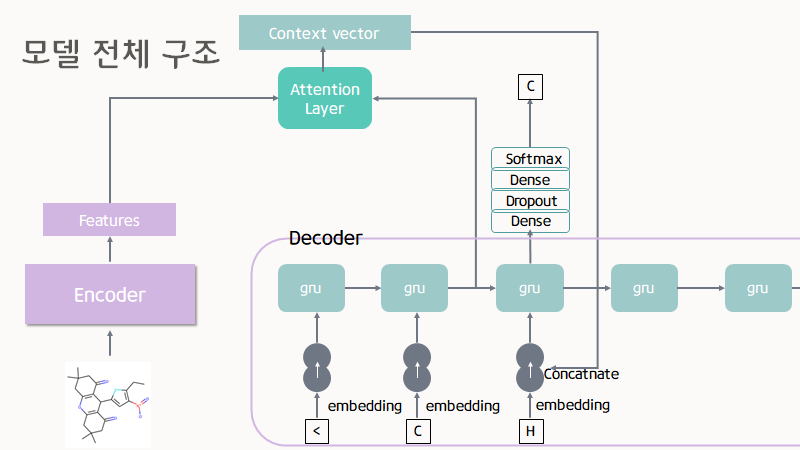

## 인코더 
Encoder는 분자구조이미지텐서를 받아서 features텐서를 리턴합니다.

인코더 내부의 자세한 과정에 대한 설명을 덧붙이자면 다음과 같습니다

#### - 입력 : (512,224,224,3)의 분자구조 이미지 텐서 (batch크기, width, height, depth)
    1.  인자로 받은 image tensor를 efficientnetB0을 이용하여 피쳐맵(batch크기,7,7,1280)을 추출합니다(image tensor는 tfrecord로부터 가져온 image_raw를    decode_image함수에 인자로 넣어서 얻은 값입니다.)
    2.  dropout을 적용합니다.
    3.  추출된 피쳐맵을 (batch크기, 49,1280)로 reshape합니다
    4.  embedding_dim(512)크기의 Dense층을 적용하고 relu 활성화 함수를 적용합니다. 
#### - 출력 : (512, 49, 512)의 encoder 피쳐 (batch크기, 49, embedding_dim)


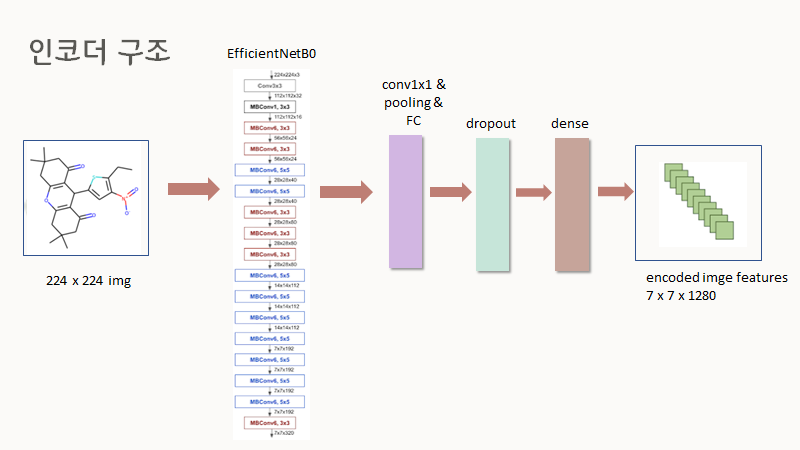

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]


class CNN_Encoder(tf.keras.Model): # tf.keras.Model을 상속받음.
  # you should define your layers in __init__ 
  def __init__(self, embedding_dim):
      super(CNN_Encoder, self).__init__() # super : 자식 클래스에서 부모클래스의 내용을 사용하고 싶을 경우 사용.
      self.base = EFNS[ef](input_shape=(224,224,3),weights='imagenet',include_top=False) # --> (None,7,7,1280)
      for i, layer in enumerate(self.base.layers): 
        layer.trainable = True
      self.dropout = tf.keras.layers.Dropout(0.25)
      self.fc = tf.keras.layers.Dense(embedding_dim, dtype='float32')

  #you should implement the model's forward pass in call.
  def call(self, x):
      x = self.base(x)
      x = self.dropout(x)
      x = tf.reshape(x, [tf.shape(x)[0],tf.shape(x)[1]*tf.shape(x)[2],feature_shape]) # (BATCH_SIZE, 49,1280)
      x = self.fc(x)
      x = tf.nn.relu(x)

      return x

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #units = 1024
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1) #Returns a tensor with a length 1 axis inserted at index axis.
        
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## 디코더
Decoder는 RNN구조이며 바다니우 어텐션을 적용하였습니다  

디코더에는 3가지 입력이 들어갑니다. 
     1.  현재 시점(t)의 word (초기 입력으로 smiles의 시작을 의미하는 '<'가 들어갑니다) tensor의 shape은 (512,49,512) 입니다
     2.  인코더에서 나온 피쳐 
     3.  디코더의 이전 시점(t-1) 은닉상태

출력은 3가지 입니다. 
     1.  현 시점(t)의 예측 word 텐서 (batch크기,37)
     2.  디코더의 현 시점(t) 은닉상태
     3.  attention weight(어텐션 가중치) --> 리턴(출력)하지만 이후 사용되지는 않습니다.

어텐션 메커니즘은 기존 인코더 투 디코더 모델의 컨텍스트 벡터를 개선함으로써 성능을 향상시키는 기법입니다.

보통 인코더가 RNN모델에 기반해 있는 인코더 투 디코더 모델(seq2seq)은 인코더의 마지막 은닉 상태를 컨텍스트 벡터로 하고 이를 디코더 RNN 셀의 첫번재 은닉 상태로 사용합니다.  
이 모델에서는 인코더가 CNN모델에 기반 해 있으므로 인코더의 최종 출력이 컨텍스트 벡터의 역할을 할 수 있습니다.

컨텍스트 벡터를 디코더의 초기 은닉 상태로만 사용하는것에서 더 나아가 컨텍스트 벡터를 디코더가 word를 예측하는 매 시점마다 하나의 입력으로 사용할 수도 있습니다. 이에 더 나아가 어텐션 메커니즘을 사용하면 더욱 문맥을 반영할 수 있는 입력을 디코더에 줄 수 있습니다. 

디코더에 적용된 어텐션 메커니즘은 출력 단어를 예측하는 매 시점마다 분자이미지전체(인코더를 통해 얻은 피쳐)를 참고하는 것입니다.(기계번역 모델이라면 전체 입력 문장을 참고한다고 보면 됩니다).단 해당 시점에서 예측해야할 word와 연관이 있는 피쳐부분을 좀더 집중(attention)하여 보는 것입니다.

디코더 내부의 gru층에는 "현재 시점(t)의 word를 embedding한 vector"와 "context_vector"를 연결하여 입력벡터로 줍니다.

### Decoder 내부의 과정에 대하여 자세하게 설명드리겠습니다.

     1.  features(인코더에서 나온 피쳐), hidden(디코더의 이전 시점(t-1) 은닉상태)를 이용하여 context_vector와 attention_weight를 구합니다.
     
        -  feature와 hidden을 이용하여 어텐션 스코어를 구하고 이에 소프트맥스를 적용하여 attention_weight를 구하는 것입니다.
        - 어텐션 스코어를 구하는 방법은 여러가지가 있습니다. 그중 바다니우가 제시한 'concat'방법을 사용합니다.
        - attention_weight와 hidden을 가중합하여 context_vector를 구합니다. 이는 Attention value라고도 합니다. 

     2.  x(현재 시점(t)의 word)를 512차원의 vector로 변환합니다. 

     3.  context_vector와 x(임베딩된 word 벡터)를 연결(concatenate)하여 gru층의 입력으로 사용합니다.

     4.  dropout을 거치고, 2개의 Dense layer를 거쳐 다음에 올 단어 예측값을 출력합니다
    

In [3]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #(37,512)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True, #메모리 셀의 각 시점(time step)의 은닉 상태값들을 모아서 전체 시퀀스를 리턴하고자 합니다
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.dropout =tf.keras.layers.Dropout(0.25)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size, dtype='float32')

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        x = self.fc1(output)
        x = self.dropout(x)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### strategy.scope()내에서 모델, Metric, 옵티마이저를 선언해 주어야 합니다. 그렇지 않으면 정상적으로 실행되지 않습니다


In [ ]:
with strategy.scope(): 
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  train_loss = tf.keras.metrics.Sum() # tf.keras.metrics.Sum은 주어진 값의 합을 계산합니다.
  valid_loss = tf.keras.metrics.Sum()
  optimizer = tf.keras.optimizers.Adam(lr=0.001)

## loss function
레이블 class가 두개 이상일때 손실함수로 crossentropy loss function를 사용합니다. 이는 label(real)과 prediction(pred)간의 crossentropy loss를 계산합니다.

SparseCategoricalCrossentropy함수는 레이블은 정수로 입력받으며, 원핫 벡터로 입력받고 싶으면 CategoricalCrossentropy를 사용해야합니다.  

여기서 real값은 디코더에서 예측할 현 시점(t)의 입력 word(글자)입니다.즉 0부터 36사이 정수(word를 숫자로 표현한것)이며,
pred값은 디코더에서 예측한 현 시점(t)의 예측된 37차원 word 텐서입니다 shape :(batch크기,37)

### pred과 real값의 예시입니다.

pred는 37차원 텐서 : [ 0.08155002, -0.01409034, -0.16667187, ...,  0.1283614 ,
         0.01665916,  0.1495304 ]
         
real은 1차원 텐서 : 1 

한번에 배치사이즈 512만큼 연산하므로 pred의 shape은 (512,37)이 되고 real의 shape은 (512,)이 됩니다

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) #0(패딩)이 아닌것만 True로 mask한다. 
    loss_ = loss_object(real, pred) # real과  pred간의 loss를 구한다.

    mask = tf.cast(mask, dtype=loss_.dtype) # True 를 1로 변경한다.
    loss_ *= mask# loss와 mask를 곱한다.

    return tf.reduce_mean(loss_) #loss의 평균을 구한다.

## GCS 에 있는 tfrecords 불러오기
TPU는 GCS (Google Cloud Storage)에서만 학습 데이터를 읽습니다. 그 이유는 TPU의 속도가 매우 빨라서  학습시 데이터 병목 현상이 발생하기 때문입니다. TPU는 데이터를 기다리느라 대부분 유휴상태있게 되는 것입니다. 
그렇기 때문에 GCS를 이용합니다. GCS에서 여러 파일을 병렬로 스트리밍하게 되면 상당 높은 처리량을 유지할 수 있습니다.
GCS에 데이터를 적절한 개수( 10개~ 100개) 적절하게 큰 용량( 10~100MB)로 설정하면 처리량이 최대화됩니다.

tfrecord파일 하나당  256개의 이미지와 라벨을 저장했지만 512*14개(90MB)의 이미지와 smiles를 저장하고 GCS에 업로드 하는것이 좋습니다

GCS 버킷을 생성하고 권한추가 --> 새 구성원:allUsers --> 역할선택 : cloud sorage,저장소 개체 뷰어 과정을 거치면 tpu에서 데이터 접근이 가능해 집니다

In [ ]:
train_tf_records = os.path.join(base_path, '*')
train_data = np.sort(np.array(tf.io.gfile.glob(train_tf_records)))

In [ ]:
print(train_data)
print(len(train_data))

## 훈련데이터와 검증 데이터셋을 분리합니다

In [ ]:
kfold = KFold(n_splits=9000, shuffle=True, random_state=42)

for i, (idx, vdx) in enumerate(kfold.split(train_data)):
    if i == 0:
      tr_data = train_data[idx]
      val_data = train_data[vdx]
      
    else:
      continue

In [ ]:
from sklearn.utils import shuffle

In [ ]:
len(tr_data)

In [ ]:
len(val_data)

In [ ]:
# tr_data = shuffle(tr_data1)
tr_data = shuffle(tr_data)

In [ ]:
tr_data

In [ ]:
len(tr_data)

In [ ]:
num_example = len(tr_data)*512*14

## tfrecords를 불러오는 함수 정의

위에서 TFrecord 파일들의 경로를 GCS에서 불러와 리스트로 저장 한 후 tr_data(훈련용), val_data(검증용)으로 나눴습니다.이 둘을 아래 직접 정의한 load_dataset 함수를 통하여 모델에 feeding가능한 형태로 만들었습니다. 

load_dataset함수의 내부의 과정에 대해 차례대로 설명드리겠습니다.

    1. 주어진 filesnames(파일경로리스트)를 가지고 tf.data.TFRecordDataset을 통해서 dataset을 생성합니다.
    
    2. cache()메서드를 이용하여 첫 반복에 데이터를 캐시하도록 합니다. 후속반복에 캐시된 데이터를 사용합니다
    
    3. repeat,과 shuffle여부를 결정합니다. shuffle시 experimental_deterministic = False로 둡니다 이는 굳이 데이터가 저장되어있는 순서대로 읽지 않음으로서 속도를 조금 빠르게 하는 것입니다.
    
    4. map을 이용하여 후처리작업을 수행합니다. map을 위한함수인 read_train_tfrecord는 tfrecord의 바이너리 스트림을 파싱하여 텐서로 바꿔주는 작업을 수행합니다.
    
    5. dataset 에 batch와 prefetch 를 적용합니다. pretetch는 데이터 입력 파이프라인 성능 최적화를 위함입니다. tf.data.experimental.AUTOTUNE으로 설정하여 tf.data런타임이 실행시에 동적으로 값을 조정하도록 만듭니다. 



In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [224,224])
    return image

def read_train_tfrecord(example):
    features = {
        'label': tf.io.FixedLenFeature([], tf.string), #고정길이 입력 피쳐를 parsing하기 위한 함수입니다
        'image_raw': tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, features) #serialized된 피쳐를 위에서 정의한 features형태로 파싱합니다
    
    data = decode_image(example['image_raw'])
    label=example['label']
    label = tf.io.decode_raw(label, out_type=tf.int32)
    
    return data, label

def load_dataset(filenames, shuffle=False, repeat=False, aug=False):
    dataset = tf.data.TFRecordDataset(filenames)
    # dataset = dataset.cache() #데이터 셋이 처음 반복될때 메모리에 캐시됩니다. 이후반복에는 캐시된 데이터를 사용합니다.
    
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(BATCH_SIZE*2)
        opt = tf.data.Options()
        
        opt.experimental_deterministic = False
    
    dataset = dataset.map(read_train_tfrecord, num_parallel_calls=AUTO)
    dataset = dataset.apply(tf.data.experimental.ignore_errors()) #to slove dataloss error
    dataset = dataset.batch(BATCH_SIZE* REPLICAS) #elements를 특정 크기로 일괄 처리하도록 결합합니다.
    dataset = dataset.prefetch(AUTO) #현재 element가 처리 되는 동안 이후 element를 준비합니다 추가 메모리를 사용하는 대신 대기 시간이 줄어들고 처리량이 향상됩니다.
    return dataset


train_dataset = load_dataset(tr_data, shuffle=True, repeat=True)
val_dataset = load_dataset(val_data, shuffle=False, repeat=False)

experimental_distribute_dataset를 사용하여 데이터셋을 학습할 머신에 맞게 분배합니다. 

In [ ]:
# PerReplica
train_dist_ds = strategy.experimental_distribute_dataset(train_dataset)
valid_dist_ds = strategy.experimental_distribute_dataset(val_dataset)

In [ ]:
num_example

In [ ]:
# STEPS_PER_EPOCH = int(num_example * 0.9998462602813437) // (BATCH_SIZE * 8)
# VAL_STEPS_PER_EPOCH = int(num_example * (1-0.9998462602813437)) // (BATCH_SIZE * 8)
STEPS_PER_EPOCH = int(num_example * ( (len(tr_data)-2) /len(tr_data))) // (BATCH_SIZE * 8)
VAL_STEPS_PER_EPOCH = int(num_example * (2/len(tr_data))) // (BATCH_SIZE * 8)

In [ ]:
STEPS_PER_EPOCH

In [ ]:
VAL_STEPS_PER_EPOCH

In [ ]:
VAL_STEPS_PER_EPOCH = 27

## 훈련스텝정의


train_step_fn는 위에서 생성한 train_dists_ds를 이용하여 학습을 진행하기 위한 함수입니다. 
함수 내부 실행과정에 대해 차례대로 설명을 드리겠습니다. 

    1. loss를 0으로 초기화하고 hidden(디코더의 은닉상태)을 초기화합니다. dec_input은 초기 입력으로 smiles의 시작을 의미하는 '<'가 들어갑니다
    hidden은 shape이 (배치크기, units)인 텐서입니다. dec_input은 (배치크기,1)입니다. 
    
    2. GradientTape내에서 이미지 텐서를 인코더에 입력해 features를 얻고 디코더에 dec_input, features hidden을 입력해 예측값을 얻습니다. 디코더의 예측은 모든 시점에 대해 반복됩니다. 시점은 72번있으며 smiles의 길이(패딩포함)입니다. 그후 pred값과 target값 사이의 loss값을 계산합니다 이후 시점 디코더의  input은 teacher forcing을 적용하기 때문에 예측값이 아니라 실제값이 들어갑니다
    
    3. encoder와 decoder의 훈련가능한 변수들(가중치와, 편향)을 합친 후 tape.gradient를 이용하여 미분을 구합니다.
    
    4. adam optimizer apply_gradients()함수로 계산된 gradient를 적용합니다.
    
    5. loss를 update함니다.

In [ ]:
@tf.function
def train_step_fn(img_tensor, target, validation=False):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tar_to_index['<']] * target.shape[0], 1)
    
    #GradientTape안에서 계산을 하면 tape안에 계산 과정을 기록해두었다가 tape.gradient를 이용하여 미분을 자동으로 구할 수 있습니다.
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden, training=True)

            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables)) #zip은 동일한 개수로 이루어진 자료형을 묶어주는 역할을 한다.

    total_loss = (loss / int(target.shape[1]))
    train_loss.update_state(total_loss)
    #return loss, total_loss

## 검증스텝 정의
valid_step_fn은 검증 loss를 구하기 위한 함수입니다.

예측값을 얻고 loss를 구하는 과정은 train_step_fn과 동일하나. gradient를 구하는 과정은 필요가 없으니 생략되었습니다. 

In [ ]:
@tf.function
def valid_step_fn(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tar_to_index['<']] * target.shape[0], 1)
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden, training=False)

        loss += loss_function(target[:, i], predictions) 

        dec_input = tf.expand_dims(target[:, i], 1) #teacher forcing

    val_loss = (loss / int(target.shape[1]))
    valid_loss.update_state(val_loss)

In [ ]:
import gc
gc.collect()

## 모델 가중치 불러오기
이전에 epoch까지 학습시킨 모델이 있다면 가중치를 불러옵니다.
가중치를 불러오기 위해서는 모델을  building하는 작업이 필요합니다. 

In [ ]:
start_epoch = 0

### load_weight를 실행하기 위해 훈련 스텝을 한번 거쳐 모델을 building합니다.
### 이전까지 학습시킨 모델가중치를 불러옵니다

In [ ]:
train_loss.reset_states()
valid_loss.reset_states()
total_loss = 0
for (batch, (img_tensor, target)) in enumerate(train_dist_ds):
  strategy.run(train_step_fn, args=(img_tensor, target))
  break

encoder.load_weights(os.path.join(ROOT_PATH, number+"_eff0_unfreeze_all_encoder_9300만.h5"))
decoder.load_weights(os.path.join(ROOT_PATH, number+"_eff0_unfreeze_all_decoder_9300만.h5"))

In [ ]:
def write_txt_from_list(path,data) : 
  with open(path, 'w') as f:
    for i in data:
      _ = f.write('%s\n' % i)

In [ ]:
def get_list_from_txt(path) : 
  with open(path,'r') as f : # file 객체를 사용한 뒤 with 블럭을 빠져나갈 때 close가 알아서 되기 때문에 편리합니다.
    data = ""
    while True : 
      s = f.readline()
      if not s : break
      data+=s
      
  data2 = data.split('\n')
  del data
  data = data2
  return data

In [ ]:
# optimizer.lr = 0.00021

In [ ]:
# import os
# ROOT_PATH ="./"
# val_loss_plot = [999,999]
# train_loss_plot =  []
# write_txt_from_list(os.path.join(ROOT_PATH, number+"_train_loss_plot.txt"),train_loss_plot)
# write_txt_from_list(os.path.join(ROOT_PATH, number+"_val_loss_plot.txt"),val_loss_plot)


In [ ]:
train_loss_plot = get_list_from_txt(os.path.join(ROOT_PATH, number+"_train_loss_plot.txt"))
val_loss_plot = get_list_from_txt(os.path.join(ROOT_PATH, number+"_val_loss_plot.txt"))

train_loss.reset_states()
valid_loss.reset_states()

In [ ]:
float(val_loss_plot[-2])

In [ ]:
optimizer.lr = 0.00021

## 훈련 시작

우선 tf.keras.metrics.Sum()로 정의된 train_loss와 valid_loss를 reset_states()함수를 호출하여 metric 상태변수를 초기화합니다. 

train_loss는 설정한 100개의 batch마다 reset_states()를 호출함으로써 초기화합니다. valid_loss도 100개의 batch마다 val_loss를 계산하고 출력한 후 초기화됩니다. 

train_dist_ds에서 batch단위로 img_tensor와 target을 불러옵니다. 반복문 안에서 strategy.run()을 이용하여 train_step_fn 함수를 replica당 하나씩 호출합니다. 이렇게 하면 8개의 TPU core에서 각각 학습이 진행되고 train_loss가 update됩니다. 

validation도 100개의 batch마다 진행되는데 검증 후 그 시점의 val_loss 가 val_best_loss보다 낮으면 인코더와 디코더의 가중치를 저장합니다. 한 epoch이 지난 후에도 weights을 따로 저장 해 둡니다.

epoch진행될수록 적절하게 learning_rate를 감소시켜야 학습이 잘 이루어 지므로 초기 lr에서  지정한 batch가 지난 후 0.93씩 곱하여 감소시킵니다. val_loss가 1보다 커져 gradient exploding현상이 일어날 징조가 보이면 이전 weight를 load합니다.


In [ ]:
import time
val_best_loss = float(val_loss_plot[-2])
train_best_loss = 999
for epoch in range(start_epoch, 100):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dist_ds):
        strategy.run(train_step_fn, args=(img_tensor, target))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result().numpy() / 100/8))
            train_best_loss = train_loss.result().numpy() / 100/8
            train_loss.reset_states()


            for val_batch, (val_img_tensor, val_target) in enumerate(valid_dist_ds):
                strategy.run(valid_step_fn, args=(val_img_tensor, val_target))
                if val_batch >= VAL_STEPS_PER_EPOCH:
                  val_loss = valid_loss.result().numpy() / val_batch / 8
                  print(val_loss)
                  if val_loss > 1 and batch>500:
                    encoder.load_weights(os.path.join(ROOT_PATH, number+"_eff0_unfreeze_all_encoder_9300만.h5"))
                    decoder.load_weights(os.path.join(ROOT_PATH, number+"_eff0_unfreeze_all_decoder_9300만.h5"))
                    optimizer.lr =  optimizer.lr * 0.93
                    print("load weight and lr decay")                  
                  
                  print('Epoch {} VAL_Batch {} Val_Loss {:.4f}'.format(epoch + 1, val_batch, val_loss))
                  if val_loss <= val_best_loss:
                    val_best_loss = val_loss
                    encoder.save_weights(os.path.join(ROOT_PATH, number+"_eff0_unfreeze_all_encoder_9300만.h5"))
                    decoder.save_weights(os.path.join(ROOT_PATH, number+'_eff0_unfreeze_all_decoder_9300만.h5'))
                    os.system("gsutil cp ./*.h5 gs://smiles_all_under_70/model/")
                    train_loss_plot.append(train_best_loss)
                    val_loss_plot.append(val_best_loss)
                    write_txt_from_list(os.path.join(ROOT_PATH, number+"_train_loss_plot.txt"),train_loss_plot)
                    write_txt_from_list(os.path.join(ROOT_PATH, number+"_val_loss_plot.txt"),val_loss_plot)
                    os.system("gsutil cp ./*.txt gs://smiles_all_under_70/model/")
                    print("weight saved")
                  valid_loss.reset_states()
                  break 
                

                    
        if batch > STEPS_PER_EPOCH:
            break
        # print(batch)
        if batch % 10000 == 0 and batch !=0 : 
            if optimizer.lr > 0.00021:
                optimizer.lr =  optimizer.lr * 0.93
                print("lr decay", optimizer.lr)
            else:
                pass
    break
    


    # encoder.save_weights(os.path.join(ROOT_PATH, "eff0_fold0_molecule_encoder_epoch_1000만"+str(epoch+1)+"_"+str(val_best_loss)+".h5"))
    # decoder.save_weights(os.path.join(ROOT_PATH, 'eff0_fold0_molecule_decoder_epoch_1000만'+str(epoch+1)+"_"+str(val_best_loss)+".h5"))  
#     if (epoch+1)%1 == 0:
#       if optimizer.lr > 0.0001:
#         optimizer.lr =  optimizer.lr * 0.5
#       else:
#         pass

    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# 참고문헌

참고 코드 : 

https://dacon.io/competitions/official/235640/codeshare/1703?page=1&dtype=recent&ptype=pub
    

설명 참고사이트 :

https://wikidocs.net/book/2155

https://blog.pingpong.us/tpu-with-tf2-and-gcp/

https://www.kaggle.com/docs/tpu

https://www.tensorflow.org/api_docs/python/tf/data

https://hcnoh.github.io/2018-11-05-tensorflow-data-module

https://www.tensorflow.org/guide/data_performance?hl=ko

https://www.tensorflow.org/guide/autodiff?hl=ko

https://www.tensorflow.org/api_docs/python/tf/GradientTape#used-in-the-notebooks_1

https://teddylee777.github.io/tensorflow/gradient-tape

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer